# Push Notificactions  
Predictive model: People interested in a product.  
Given a user and a product, predict if the wuold buy it if theywere buying at that moment.  
user with basket > 5 products
Linear model

## Getting ready

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.figure
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score

import joblib

pd.options.display.max_columns = None
pd.options.display.max_rows = 10

### Functions

In [2]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: tuple[matplotlib.figure.Figure, np.array] = None,
):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1,2, figsize=(14,7))
    else:
        fig, ax = figure

    ax[0].plot(recall, precision, label=f"{model_name}: AUC:{pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(F"precision-recall Curve")
    ax[0].legend()

    ax[1].plot(fpr,tpr,label=f"{model_name} - AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC Curve")
    ax[1].legend()

In [3]:
def standardization_columns_categorical_encoding(
        dataframe: pd.DataFrame,
        column: str
    ):
    dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[column])],axis=1)
    dataframe = dataframe.drop(column,axis=1)
    return dataframe

### Load the data

In [4]:
#folder_path = Path("D:/Users/maick/Desktop/Codigos/zrive-ds/data/box_builder_dataset/feature_frame.csv")
folder_path = Path("C:/Users/AULA04/Desktop/Codes/zrive-ds/data/box_builder_dataset/feature_frame.csv")

In [5]:
feature_frame = pd.read_csv(folder_path)

## Preparation of the dataset

Filter for >5 products

In [6]:
size_of_order = feature_frame.groupby("order_id").outcome.sum()
size_of_order = size_of_order[size_of_order>=5]
feature_frame = feature_frame[feature_frame["order_id"].isin(size_of_order.index)]
feature_frame

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,33826439594116,healthcarevitamins,3643241300100,3864791220356,2021-03-03 12:56:04,2021-03-03 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [7]:
(feature_frame["outcome"]).value_counts()

outcome
0.0    2132624
1.0      31329
Name: count, dtype: int64

pass to datetime

In [8]:
feature_frame["created_at"] = pd.to_datetime(feature_frame["created_at"])
feature_frame["order_date"] = pd.to_datetime(feature_frame["order_date"]).dt.date

The 70% of orders were before the 2021-02-04
The 90% of orders were before the 2021-02-22


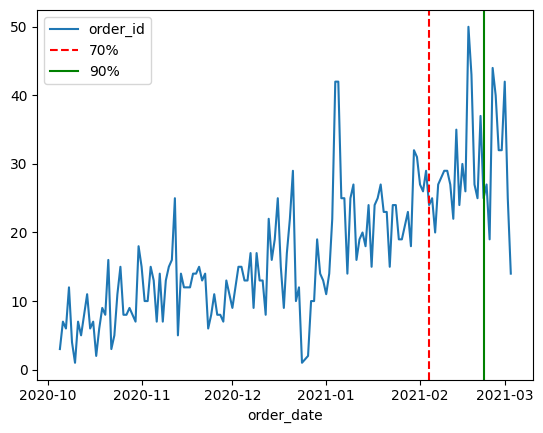

In [9]:
orders_diary = feature_frame.groupby("order_date").order_id.nunique()
porcentaje_orders_dairy = orders_diary.cumsum() / orders_diary.sum()

train_val_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy<=0.7].idxmax()
val_test_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy<=0.9].idxmax()

print(f"The 70% of orders were before the {train_val_cutoff}")
print(f"The 90% of orders were before the {val_test_cutoff}")
orders_diary.plot(kind="line")
plt.axvline(x=pd.to_datetime(train_val_cutoff), color='red', linestyle='--', label="70%")
plt.axvline(x=pd.to_datetime(val_test_cutoff), color='green', linestyle='-', label="90%")
plt.legend()

In [10]:
feature_frame = (feature_frame.sort_values("order_date",ascending=True).reset_index()).drop("index",axis = 1)
feature_frame

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33667182035076,shavinggrooming,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,33667182035076,shavinggrooming,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,33667182035076,shavinggrooming,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,33667209199748,dishwasherdetergent,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.067498,0.160643,ecover,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,34276570824836,condimentsdressings,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03,2,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,aspall,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163949,34276570824836,condimentsdressings,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03,7,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,aspall,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884
2163950,34276570824836,condimentsdressings,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03,4,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,aspall,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163951,33826456961156,babyfood6months,3643229274244,3536923295876,2021-03-03 12:36:28,2021-03-03,4,0.0,0.0,0.0,0.0,0.0,0.034969,0.155039,annabelkarmel,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072


### Columns no numeric

#### Product type

In [12]:
# Delete:
feature_frame = feature_frame.drop("variant_id",axis=1)
feature_frame = feature_frame.drop("user_id",axis=1)
feature_frame = feature_frame.drop("created_at",axis=1)
feature_frame = feature_frame.drop("order_id",axis=1)

In [ ]:
feature_frame

### Separate the dataframe

In [13]:
column_numerics = []
for columns in feature_frame.dtypes:
    if columns == "int64" or columns == "float64":
        column_numerics.append(True)
    else:
        column_numerics.append(False)

feature_frame_numeric = feature_frame.loc[:, column_numerics]
feature_frame_numeric

,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,4,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,2,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,3,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,3,0.0,0.0,0.0,0.0,0.0,0.067498,0.160643,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,2,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163949,7,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884
2163950,4,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163951,4,0.0,0.0,0.0,0.0,0.0,0.034969,0.155039,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072


## Divide the dataset

In [14]:
y = feature_frame_numeric["outcome"]
x = feature_frame_numeric.drop(columns=["outcome"])

I try two ways to divide the dataset to view the diferent results
1. Randomly, 10% data for test, aprox 20% for valid and aprox 80% for train 

### Random

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train, random_state=42)

print(f"Train: {len(x_train)} ")
print(f"Valid: {len(x_valid)} ")
print(f"Test: {len(x_test)} ") 

### Temporarily

2. Temporarily, where the 70% goes until 2021-02-04 division for test and valid goes until 2021-02-22

In [31]:
x_train = x.iloc[:int(len(x)*0.7)]
x_test = x.iloc[int(len(x)*0.7):int(len(x)*0.9)]
x_valid = x.iloc[int(len(x)*0.9):]

y_train = y.iloc[:int(len(y)*0.7)]
y_test = y.iloc[int(len(y)*0.7):int(len(y)*0.9)]
y_valid = y.iloc[int(len(y)*0.9):]

print(f"Train: {len(x_train)} and {len(y_train)} ")
print(f"Valid: {len(x_valid)} and {len(y_valid)}")
print(f"Test: {len(x_test)} and {len(y_test)}") 

Train: 1514767 and 1514767 
Valid: 216396 and 216396
Test: 432790 and 432790


In [ ]:
#checking
(x_train.shape[0]+x_test.shape[0]+x_valid.shape[0] == len(x)
and
y_train.shape[0]+y_test.shape[0]+y_valid.shape[0] == len(y))

In [32]:
x_train

KeyboardInterrupt: 

## Normalization

In [34]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=x.columns)
x_train

,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,-0.187516,-0.165028,-0.03001,-0.058658,-0.045504,-0.354472,-0.687650,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,0.605794,0.625504,-0.102901,-0.278898,-0.648814
1,0.264409,-0.165028,-0.03001,-0.058658,-0.045504,0.122921,-0.370028,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,0.508454,-1.207610,-0.102901,0.987535,0.351645
2,-0.639442,-0.165028,-0.03001,-0.058658,-0.045504,0.122921,-0.370028,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,0.508454,-1.207610,-0.102901,0.987535,0.351645
3,-0.187516,-0.165028,-0.03001,-0.058658,-0.045504,0.122921,-0.370028,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,0.508454,-1.207610,-0.102901,0.987535,0.351645
4,-0.187516,-0.165028,-0.03001,-0.058658,-0.045504,-0.462971,-0.139667,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,0.508454,0.532997,-0.102901,0.227675,-0.102415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514762,2.524038,-0.165028,-0.03001,-0.058658,-0.045504,1.923997,-0.275058,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,1.968558,0.124811,-1.863788,-1.545330,-1.774991
1514763,-0.639442,-0.165028,-0.03001,-0.058658,-0.045504,1.923997,-0.275058,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,1.968558,0.124811,-1.687699,-1.545330,-1.774991
1514764,-0.639442,-0.165028,-0.03001,-0.058658,-0.045504,1.923997,-0.275058,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,1.968558,0.124811,-0.807256,-1.545330,-1.774991
1514765,0.716335,-0.165028,-0.03001,-0.058658,-0.045504,-0.506370,-0.492298,-0.581481,-0.107538,-0.186455,-0.067617,6.077913,-0.21032,-0.03058,1.579197,0.438958,-0.102901,1.240821,1.129515


## Baseline

In [ ]:
baseline_predictions = (feature_frame["global_popularity"] >= 0.5).astype(int)

print("Validación:\n", classification_report(feature_frame["outcome"], baseline_predictions))

In [ ]:
plot_metrics("popularity baseline", y_pred=feature_frame["global_popularity"], y_test=feature_frame["outcome"])

### LogisticRegression

#### model basic

In [ ]:
#model basic
LogReg_model = LogisticRegression(
    class_weight="balanced", 
    random_state=29,
    )

LogReg_model.fit(x_train, y_train)

In [ ]:
y_test_pred_LogReg_model = LogReg_model.predict(x_test)
print("Validación:\n", classification_report(y_test, y_test_pred_LogReg_model))
print(f"Validation Score recall: {cross_val_score(LogReg_model, x_train, y_train, cv=5, scoring='recall').mean()}")

#### model regulation Ridge

In [35]:
#C = 0.1
LogReg_ridge_model = LogisticRegression(
    penalty="l2",
    C=0.1,
    class_weight="balanced", 
    random_state=29,
    )

LogReg_ridge_model.fit(x_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', random_state=29)

In [37]:
y_test_pred_LogReg_ridge_model = LogReg_ridge_model.predict(x_test)
print("Validación:\n", classification_report(y_test, y_test_pred_LogReg_ridge_model))
print(f"Validation Score recall: {cross_val_score(LogReg_ridge_model, x_train, y_train, cv=5, scoring='recall').mean()}")

Validación:
               precision    recall  f1-score   support

         0.0       0.99      0.96      0.97    426947
         1.0       0.02      0.06      0.03      5843

    accuracy                           0.95    432790
   macro avg       0.51      0.51      0.50    432790
weighted avg       0.97      0.95      0.96    432790

Validation Score recall: 0.6269777040235809


In [ ]:
#train graph
fig1, ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Validations metrics")

plot_metrics(
    f"Baseline",y_pred=feature_frame["global_popularity"],y_test=feature_frame["outcome"],figure=(fig1,ax1)
)
y_test_proba_LogReg_model = LogReg_model.predict_proba(x_train)[:,1]
plot_metrics(
    f"Logistic regresion",y_pred=y_test_proba_LogReg_model,y_test=y_train,figure=(fig1,ax1)
)
y_test_proba_LogReg_ridge_model = LogReg_ridge_model.predict_proba(x_train)[:,1]
plot_metrics(
    f"Logistic regresion ridge",y_pred=y_test_proba_LogReg_ridge_model,y_test=y_train,figure=(fig1,ax1)
)

In [ ]:
#Validation graph
fig1, ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Validations metrics")

plot_metrics(
    f"Baseline",y_pred=feature_frame["global_popularity"],y_test=feature_frame["outcome"],figure=(fig1,ax1)
)
y_test_proba_LogReg_model = LogReg_model.predict_proba(x_test)[:,1]
plot_metrics(
    f"Logistic regresion",y_pred=y_test_proba_LogReg_model,y_test=y_test,figure=(fig1,ax1)
)
y_test_proba_LogReg_ridge_model = LogReg_ridge_model.predict_proba(x_test)[:,1]
plot_metrics(
    f"Logistic regresion ridge",y_pred=y_test_proba_LogReg_ridge_model,y_test=y_test,figure=(fig1,ax1)
)

# l

In [ ]:
fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validations metrics")

cs = [1e-8,1e-6,1e-4,1e-2,1,100,1e4,None]
for c in cs:
    LogReg_model = LogisticRegression(penalty="l2",C=c if c else 1.0)
    LogReg_model.fit(x_train,y_train)
    train_proba = LogReg_model.predict_proba(x_train)[:,1]
    plot_metrics(
        f"LR; C={c}",y_pred=train_proba,y_test=y_train,figure=(fig1,ax1)
    )
    
    val_proba = LogReg_model.predict_proba(x_valid)[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=y_valid, figure=(fig2, ax2)
    )

plot_metrics(
    f"Baseline",
    y_pred=x_train["global_popularity"],
    y_test=y_train,
    figure=(fig2,ax2),
)

Lasso Regression

In [ ]:
fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validations metrics")

cs = [1e-8,1e-6,1e-4,1e-2,1,100,1e4,None]
for c in cs:
    LogReg_model = LogisticRegression(penalty="l1",C=c if c else 1.0, solver="saga")
    LogReg_model.fit(x_train,y_train)
    train_proba = LogReg_model.predict_proba(x_train)[:,1]
    plot_metrics(
        f"LR; C={c}",y_pred=train_proba,y_test=y_train,figure=(fig1,ax1)
    )
    
    val_proba = LogReg_model.predict_proba(x_valid)[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=y_valid, figure=(fig2, ax2)
    )

plot_metrics(
    f"Baseline",
    y_pred=x_train["global_popularity"],
    y_test=y_train,
    figure=(fig2,ax2),
)

Importancia de Coeficientes

In [ ]:
feature_importance = pd.DataFrame({
    "Feature": [f"Feature_{i}" for i in x_train.columns],
    "Weight": abs(LogReg_model.coef_[0])  # Coeficientes del modelo
}).sort_values(by="Weight", ascending=False)
feature_importance

#### Added the column of product type in categorical encoding

In [15]:
product_type_categorical_encoding = pd.get_dummies(feature_frame["product_type"])
product_type_categorical_encoding*1
x_product_type = pd.concat([x,product_type_categorical_encoding*1],axis=1)
x_product_type

,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,airfreshener,allpurposecleaner,babyfood12months,babyfood6months,babymilkformula,babytoiletries,bathroomlimescalecleaner,bathshowergel,beer,binbags,bodyskincare,catfood,cereal,cleaningaccessories,coffee,condimentsdressings,cookingingredientsoils,cookingsaucesmarinades,delicatesstainremover,dental,deodorant,dishwasherdetergent,dogfood,driedfruitsnutsseeds,dryingironing,fabricconditionerfreshener,facialskincare,feedingweaning,femininecare,floorcleanerpolish,foodstorage,haircare,handsoapsanitisers,healthcarevitamins,homebaking,householdsundries,jamhoneyspreads,juicesquash,kidsdental,kidssnacks,kitchenovencleaner,kitchenrolltissues,longlifemilksubstitutes,maternity,nappies,nappypants,petcare,pickledfoodolives,premixedcocktails,ricepastapulses,shavinggrooming,snacksconfectionery,softdrinksmixers,superfoodssupplements,tea,tinspackagedfoods,toiletroll,washingcapsules,washingliquidgel,washingpowder,windowglasscleaner,wipescottonwool
0,3,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,4,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,3,0.0,0.0,0.0,0.0,0.067498,0.160643,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,2,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2163949,7,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2163950,4,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2163951,4,0.0,0.0,0.0,0.0,0.034969,0.155039,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
x_train_pt = x_product_type.iloc[:int(len(x_product_type)*0.7)]
x_test_pt = x_product_type.iloc[int(len(x_product_type)*0.7):int(len(x)*0.9)]
x_valid_pt = x_product_type.iloc[int(len(x_product_type)*0.9):]

y_train = y.iloc[:int(len(y)*0.7)]
y_test = y.iloc[int(len(y)*0.7):int(len(y)*0.9)]
y_valid = y.iloc[int(len(y)*0.9):]

print(f"Train: {len(x_train_pt)} and {len(y_train)} ")
print(f"Valid: {len(x_valid_pt)} and {len(y_valid)}")
print(f"Test: {len(x_test_pt)} and {len(y_test)}")


Train: 1514767 and 1514767 
Valid: 216396 and 216396
Test: 432790 and 432790


In [20]:
x_train_pt

array([[-0.18751624, -0.16502841, -0.03001031, ..., -0.07099229,
        -0.06144243, -0.10664199],
       [ 0.26440943, -0.16502841, -0.03001031, ..., -0.07099229,
        -0.06144243, -0.10664199],
       [-0.63944191, -0.16502841, -0.03001031, ..., -0.07099229,
        -0.06144243, -0.10664199],
       ...,
       [-0.63944191, -0.16502841, -0.03001031, ..., -0.07099229,
        -0.06144243, -0.10664199],
       [ 0.7163351 , -0.16502841, -0.03001031, ..., -0.07099229,
        -0.06144243, -0.10664199],
       [ 1.16826077, -0.16502841, -0.03001031, ..., -0.07099229,
        -0.06144243, -0.10664199]])

In [21]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
x_train_pt = scaler.fit_transform(x_train_pt)
x_train_pt = pd.DataFrame(x_train_pt, columns=x_product_type.columns)
x_train_pt

,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,airfreshener,allpurposecleaner,babyfood12months,babyfood6months,babymilkformula,babytoiletries,bathroomlimescalecleaner,bathshowergel,beer,binbags,bodyskincare,catfood,cereal,cleaningaccessories,coffee,condimentsdressings,cookingingredientsoils,cookingsaucesmarinades,delicatesstainremover,dental,deodorant,dishwasherdetergent,dogfood,driedfruitsnutsseeds,dryingironing,fabricconditionerfreshener,facialskincare,feedingweaning,femininecare,floorcleanerpolish,foodstorage,haircare,handsoapsanitisers,healthcarevitamins,homebaking,householdsundries,jamhoneyspreads,juicesquash,kidsdental,kidssnacks,kitchenovencleaner,kitchenrolltissues,longlifemilksubstitutes,maternity,nappies,nappypants,petcare,pickledfoodolives,premixedcocktails,ricepastapulses,shavinggrooming,snacksconfectionery,softdrinksmixers,superfoodssupplements,tea,tinspackagedfoods,toiletroll,washingcapsules,washingliquidgel,washingpowder,windowglasscleaner,wipescottonwool
0,-0.187516,-0.165028,-0.03001,-0.058658,-0.045504,-0.354472,-0.687650,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,0.605794,0.625504,-0.102901,-0.278898,-0.648814,-0.060565,-0.137564,-0.035429,-0.119776,-0.035429,-0.138540,-0.176082,-0.147467,-0.00445,-0.070992,-0.106825,-0.133457,-0.180218,-0.133564,-0.142232,-0.22053,-0.200292,-0.100649,-0.082317,-0.154119,-0.093992,-0.191613,-0.124503,-0.128715,-0.061442,-0.12317,-0.132591,0.0,-0.132843,-0.086807,-0.095626,-0.207915,-0.145377,-0.087057,-0.135803,-0.049302,-0.15467,-0.106474,-0.061599,-0.160464,-0.118327,-0.106838,-0.203128,-0.050321,-0.130942,-0.123518,-0.035429,-0.139153,0.0,4.547845,-0.121203,-0.138049,-0.128131,-0.096082,-0.138369,-0.289141,-0.059919,-0.050136,-0.135896,-0.070992,-0.061442,-0.106642
1,0.264409,-0.165028,-0.03001,-0.058658,-0.045504,0.122921,-0.370028,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,0.508454,-1.207610,-0.102901,0.987535,0.351645,-0.060565,-0.137564,-0.035429,-0.119776,-0.035429,-0.138540,-0.176082,-0.147467,-0.00445,-0.070992,-0.106825,-0.133457,-0.180218,-0.133564,-0.142232,-0.22053,-0.200292,-0.100649,-0.082317,-0.154119,-0.093992,-0.191613,-0.124503,-0.128715,-0.061442,-0.12317,-0.132591,0.0,-0.132843,-0.086807,-0.095626,-0.207915,-0.145377,-0.087057,-0.135803,-0.049302,-0.15467,-0.106474,-0.061599,-0.160464,-0.118327,-0.106838,-0.203128,-0.050321,-0.130942,-0.123518,-0.035429,-0.139153,0.0,-0.219884,8.250626,-0.138049,-0.128131,-0.096082,-0.138369,-0.289141,-0.059919,-0.050136,-0.135896,-0.070992,-0.061442,-0.106642
2,-0.639442,-0.165028,-0.03001,-0.058658,-0.045504,0.122921,-0.370028,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,0.508454,-1.207610,-0.102901,0.987535,0.351645,-0.060565,-0.137564,-0.035429,-0.119776,-0.035429,-0.138540,-0.176082,-0.147467,-0.00445,-0.070992,-0.106825,-0.133457,-0.180218,-0.133564,-0.142232,-0.22053,-0.200292,-0.100649,-0.082317,-0.154119,-0.093992,-0.191613,-0.124503,-0.128715,-0.061442,-0.12317,-0.132591,0.0,-0.132843,-0.086807,-0.095626,-0.207915,-0.145377,-0.087057,-0.135803,-0.049302,-0.15467,-0.106474,-0.061599,-0.160464,-0.118327,-0.106838,-0.203128,-0.050321,-0.130942,-0.123518,-0.035429,-0.139153,0.0,-0.219884,8.250626,-0.138049,-0.128131,-0.096082,-0.138369,-0.289141,-0.059919,-0.050136,-0.135896,-0.070992,-0.061442,-0.106642
3,-0.187516,-0.165028,-0.03001,-0.058658,-0.045504,0.122921,-0.370028,-0.677075,-0.107538,-0.186455,-0.067617,-0.191606,-0.21032,-0.03058,0.508454,-1.207610,-0.102901,0.987535,0.351645,-0.060565,-0.137564,-0.035429,-0.119776,-0.035429,-0.138540,-0.176082,-0.147467,-0.00445,-0.070992,-0.106825,-0.133457,-0.180218,-0.133564,-0.1

In [22]:
#model basic
LogReg_model_categorical_type = LogisticRegression(
    class_weight="balanced", 
    random_state=29,
    )

LogReg_model_categorical_type.fit(x_train_pt, y_train)

LogisticRegression(class_weight='balanced', random_state=29)

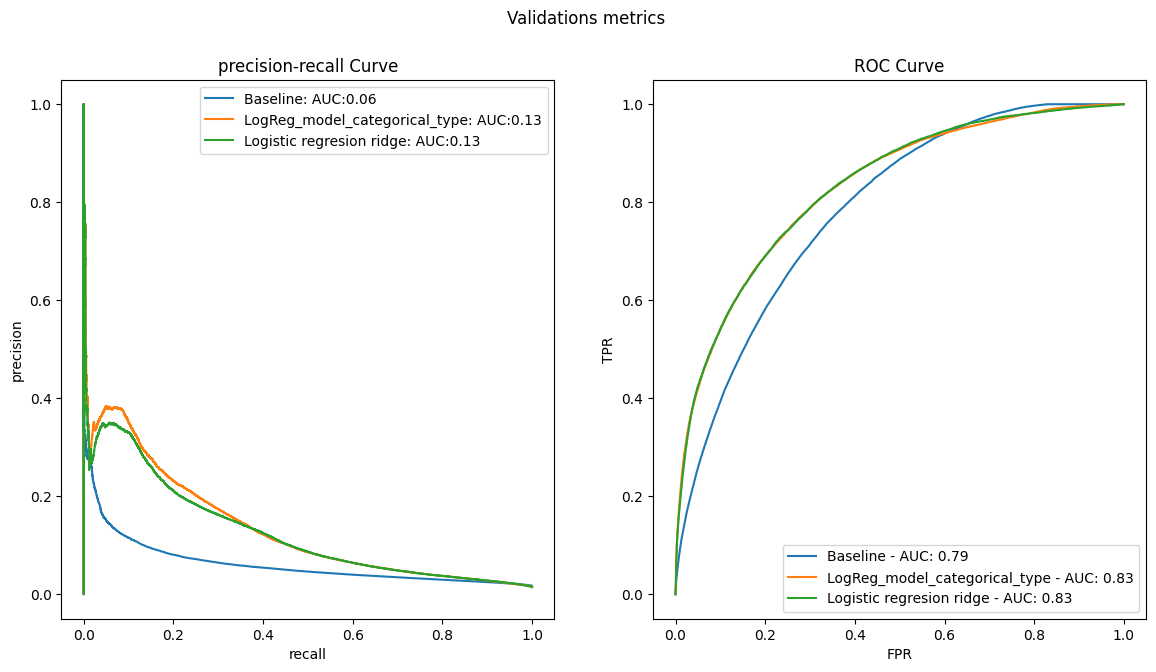

In [39]:
#train graph
fig1, ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.suptitle("Validations metrics")

plot_metrics(
    f"Baseline",y_pred=feature_frame["global_popularity"],y_test=feature_frame["outcome"],figure=(fig1,ax1)
)
y_test_proba_LogReg_model = LogReg_model_categorical_type.predict_proba(x_train_pt)[:,1]
plot_metrics(
    f"LogReg_model_categorical_type",y_pred=y_test_proba_LogReg_model,y_test=y_train,figure=(fig1,ax1)
)
y_test_proba_LogReg_ridge_model = LogReg_ridge_model.predict_proba(x_train)[:,1]
plot_metrics(
    f"Logistic regresion ridge",y_pred=y_test_proba_LogReg_ridge_model,y_test=y_train,figure=(fig1,ax1)
)

In [24]:
pd.options.display.max_rows = None
feature_importance = pd.DataFrame({
    "Feature": [f"Feature_{i}" for i in x_train_pt.columns],
    "Weight": abs(LogReg_model_categorical_type.coef_[0])  # Coeficientes del modelo
}).sort_values(by="Weight", ascending=False)
feature_importance

,Feature,Weight
7,Feature_global_popularity,0.740098
1,Feature_ordered_before,0.402241
63,Feature_nappies,0.260038
64,Feature_nappypants,0.193454
21,Feature_babyfood12months,0.157941
2,Feature_abandoned_before,0.156583
29,Feature_bodyskincare,0.145597
22,Feature_babyfood6months,0.140446
5,Feature_normalised_price,0.123071
23,Feature_babymilkformula,0.118476


In [ ]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


with open("modelo_entrenado.pkl", "rb") as f:
    modelo_cargado = pickle.load(f)

joblib.dump(model, "modelo_entrenado.pkl")
